/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.13.1+cu117 0.14.1+cu117
====================0=========================


100%|████████████| 169001437/169001437 [00:10<00:00, 16413513.60it/s]


Extracting /root/.torch/cifar-100-python.tar.gz to /root/.torch
Running on cpu
GT label is 84. 
Onehot label is 84.
torch.Size([12, 3, 5, 5]) True
torch.Size([12]) True
torch.Size([12, 12, 5, 5]) True
torch.Size([12]) True
torch.Size([12, 12, 5, 5]) True
torch.Size([12]) True
torch.Size([12, 12, 5, 5]) True
torch.Size([12]) True
torch.Size([100, 768]) True
10000
20000
30000
40000


KeyboardInterrupt: 

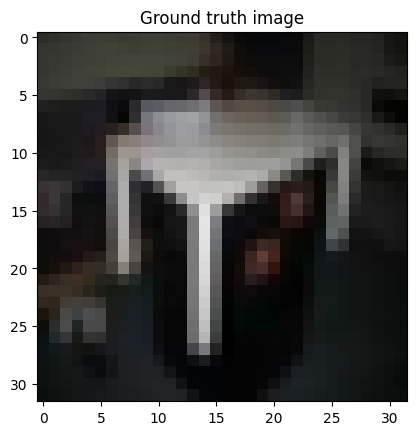

In [1]:
import numpy as np
from pprint import pprint
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
import torchvision
from torchvision import models, datasets, transforms
torch.manual_seed(50)

print(torch.__version__, torchvision.__version__)

# for i in [[0,1,2],[1,2,3], [2,3,4], [3,4,5],[4,5,6],[5,6,7],[6,7,8],[7,8,9]]:
for i in range(1):
    print(f"===================={i}=========================")
    interval = 10
    class_num = 100
    
    dst = datasets.CIFAR100("~/.torch", download=True)
    tp = transforms.Compose([
        transforms.Resize(32),
        transforms.CenterCrop(32),
        transforms.ToTensor()
    ])
    tt = transforms.ToPILImage()

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
    print("Running on %s" % device)

    def label_to_onehot(target, num_classes=class_num):
        target = torch.unsqueeze(target, 1)
        onehot_target = torch.zeros(target.size(0), num_classes, device=target.device)
        onehot_target.scatter_(1, target, 1)
        return onehot_target

    def cross_entropy_for_onehot(pred, target):
        return torch.mean(torch.sum(- target * F.log_softmax(pred, dim=-1), 1))

    def weights_init(m):
        if hasattr(m, "weight"):
            m.weight.data.uniform_(-0.5, 0.5)
        if hasattr(m, "bias"):
            m.bias.data.uniform_(-0.5, 0.5)
        
    class LeNet(nn.Module):
        def __init__(self):
            super(LeNet, self).__init__()
            act = nn.Sigmoid
            self.body = nn.Sequential(
                nn.Conv2d(3, 12, kernel_size=5, padding=5//2, stride=2),
                act(),
                nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=2),
                act(),
                nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
                act(),
                nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
                act(),
            )
            self.fc = nn.Sequential(
                nn.Linear(768, class_num)
            )
            
        def forward(self, x):
            out = self.body(x)
            out = out.view(out.size(0), -1)
            # print(out.size())
            out = self.fc(out)
            return out
        
    net = LeNet().to(device)
        
    net.apply(weights_init)
    criterion = cross_entropy_for_onehot

    ######### honest partipant #########
    img_index = 25
    gt_data = tp(dst[img_index][0]).to(device)
    gt_data = gt_data.view(1, *gt_data.size())
    gt_label = torch.Tensor([dst[img_index][1]]).long().to(device)
    gt_label = gt_label.view(1, )
    gt_onehot_label = label_to_onehot(gt_label, num_classes=class_num)

    plt.imshow(tt(gt_data[0].cpu()))
    plt.title("Ground truth image")
    print("GT label is %d." % gt_label.item(), "\nOnehot label is %d." % torch.argmax(gt_onehot_label, dim=-1).item())




    gt_data.requires_grad = True
    gt_onehot_label.requires_grad = True
    # compute original gradient 
    out = net(gt_data)
    y = criterion(out, gt_onehot_label)

    dy_dx = torch.autograd.grad(y, net.parameters(), create_graph=True)


    #grads = []

    sensitivity_each_element = []
    #sensitivity_each_layer = []
    for layer_grad in dy_dx:
        
        print(layer_grad.shape, layer_grad.requires_grad)
        sensitivity_each_element_current_layer = torch.zeros_like(layer_grad.view(-1))
        #grad_of_layer_grad_to_y = []
        count = 0
        for each_element_grad in layer_grad.view(-1):
                each_element_grad_to_y = torch.autograd.grad(each_element_grad, gt_onehot_label, retain_graph=True)[0][:,gt_label]
                sensitivity_each_element_current_layer[count] = each_element_grad_to_y
                #grad_of_layer_grad_to_y.append(each_element_grad_to_y.numpy()) 
                count += 1
                if count % 10000 == 0:
                    print(count)

        #grad_of_layer_grad_to_y = torch.tensor(np.array(grad_of_layer_grad_to_y))
        #grads.append(grad_of_layer_grad_to_y)
        #sensitivity_each_layer.append(calculate_sensitivity_vector_range(grad_of_layer_grad_to_y))
        sensitivity_each_element.append(sensitivity_each_element_current_layer)

    flat_sensitivity_each_element = flat_grad(sensitivity_each_element)






In [ ]:
def get_top_k_mask(vector, p = 0.1):

    top_k_indices = torch.topk(vector, int(len(vector) * p), largest = True).indices

    Mask = torch.zeros(vector.shape) == 0
    Mask[top_k_indices] = False
    return Mask

In [ ]:
torch.save(flat_sensitivity_each_element, 'flat_sensitivity_each_element.pt')

In [ ]:

    original_dy_dx = list((_.detach().clone() for _ in dy_dx))
    flat_original_dy_dx = flat_grad(original_dy_dx) #flat gradients to a vector

    mask = get_top_k_mask(flat_sensitivity_each_element.abs(), 0.4)
    
    new_mask = torch.ones(flat_original_dy_dx.shape)
    new_mask[:len(mask)] = mask
    mask = new_mask
    
    flat_original_dy_dx = flat_original_dy_dx * mask
    
    gt_data.requires_grad = False
    gt_onehot_label.requires_grad = False

    # generate dummy data and label
    dummy_data = torch.randn(gt_data.size()).to(device).requires_grad_(True)
    dummy_label = torch.randn(gt_onehot_label.size()).to(device).requires_grad_(True)

    plt.imshow(tt(dummy_data[0].cpu()))
    plt.title("Dummy data")
    print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())

    from ctypes import sizeof
    optimizer = torch.optim.LBFGS([dummy_data, dummy_label])

    history = []
    mses = []
    losses = []
    for iters in range(30*interval):
        def closure():
            optimizer.zero_grad()

            pred = net(dummy_data) 
            dummy_onehot_label = F.softmax(dummy_label, dim=-1)
            dummy_loss = criterion(pred, dummy_onehot_label) # TODO: fix the gt_label to dummy_label in both code and slides.
            dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)
            
            
            
            flat_dummy_dy_dx = flat_grad(dummy_dy_dx)
            
            flat_dummy_dy_dx = flat_dummy_dy_dx * mask  #with mask

            grad_diff = ((flat_dummy_dy_dx - flat_original_dy_dx) ** 2).sum()
            
            grad_diff.backward()
            losses.append(grad_diff.item())
            return grad_diff
        
        optimizer.step(closure)


        gt_arr = np.array(gt_data.cpu())
        dummy_arr = np.array(dummy_data.detach().clone()[0].cpu())
        mse = ((gt_arr - dummy_arr) ** 2).mean()
        mses.append(mse)


        if iters % interval == 0: 
            print(f"{iters}, mse={mses[iters]}, loss = {losses[iters]}")
        history.append(tt(dummy_data[0].cpu()))
        

    # print(f"losses = {losses}")

    plt.figure(figsize=(12, 8))
    for i in range(30):
        ite_num = i * interval + interval - 1 
        plt.subplot(3, 10, i + 1)
        plt.imshow(history[ite_num] )
        plt.title("iter=%d" % (ite_num+1))
        plt.axis('off')


    filename = 'CIFAR'+str(class_num)+'_'+ str(30*interval) + 'ite_' + str(protected_layers) +'.png'
    plt.savefig(filename)


    plt.figure()
    best_mse=min(mses[0:interval * 30])
    idx = mses.index(best_mse)
    print(f"idx = {idx}, len = {len(mses)}")
    plt.imshow(history[idx])
    plt.title(f"best recovered image: ite={idx}, losses={best_mse}")
    filename = 'single_mse_' + filename
    plt.savefig(filename)


    print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())




